# Burger's Equation

Burger's equation combines **nonlinear convection** (wave steepening) with **diffusion** (smoothing), making it one of the most important PDEs in fluid dynamics:

$$\frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}$$

**Where:**
- $u(t, x)$ = velocity at position $x$ and time $t$
- $u\frac{\partial u}{\partial x}$ = nonlinear convection term (tall parts travel faster → wave steepens)
- $\nu \frac{\partial^2 u}{\partial x^2}$ = diffusion term (smooths sharp gradients out)
- $\nu = \frac{0.01}{\pi}$ = viscosity (how strongly diffusion resists steepening)

**Physical meaning:** Two forces are in a tug of war. Convection wants to steepen the wave into a shock. Diffusion wants to spread it out and smooth it. The viscosity $\nu$ controls who wins.

---

## This Problem Setup

**Domain:** $x \in [0, 3]$, $t \in [0, 2]$

**Initial Condition:**
$$u(x, 0) = \begin{cases} \sin(\pi x) & x \leq 1 \\ 0 & x > 1 \end{cases}$$

A sine pulse lives in the first unit of the domain, with flat zero velocity beyond it. Watch how the pulse steepens and diffuses as time evolves.

**Boundary Conditions (Dirichlet):**
$$u(0, t) = 0 \quad \text{and} \quad u(3, t) = 0$$

The velocity is fixed at zero at both walls for all time — like fluid pinned at the edges of a channel.

In [47]:
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jax import random, grad, jit, vmap
import optax

import jax.numpy as jnp

import copy

# Problem parameters

v = 0.01/jnp.pi  # viscosity
L = 3.0  # length of domain
T = 2.0  # final time

# 1. Initial Condition points (10 points at t=0)
# t_ic = jnp.zeros((10, 1))
# x_ic = jnp.linspace(0, 1, 10).reshape(-1, 1)
# u_ic = jnp.sin(jnp.pi * x_ic)


# Initial condition:
x_ic = jnp.linspace(0, L, 50).reshape(-1, 1)  # Sample whole domain
t_ic = jnp.zeros((50, 1))

# u = sin(πx) for x ≤ 1, otherwise u = 0
u_ic = jnp.where(x_ic <= 1.0, 
                 jnp.sin(jnp.pi * x_ic), 
                 0.0)

# 2. Boundary Condition points (20 total: 10 at each edge)

"""
# Using periodic boundaries

# Left boundary (x=0):
t_bc_left = jnp.linspace(0, 1, 10).reshape(-1, 1)
x_bc_left = jnp.zeros((10, 1))

# Right boundary (x=1):
t_bc_right = jnp.linspace(0, 1, 10).reshape(-1, 1)
x_bc_right = jnp.ones((10, 1))

# Combine them:
t_bc = jnp.concatenate([t_bc_left, t_bc_right])
x_bc = jnp.concatenate([x_bc_left, x_bc_right])
u_bc = jnp.zeros((20, 1))
"""
# Using Dirichlet boundaries: u(0, t) = 0, u(L, t) = 0 - fixed values at edges

# 2. Boundary Condition points (20 total: 10 at each edge)
# Left boundary (x=0):
t_bc_left = jnp.linspace(0, T, 10).reshape(-1, 1)
x_bc_left = jnp.zeros((10, 1))

# Right boundary (x=1):
t_bc_right = jnp.linspace(0, T, 10).reshape(-1, 1)
x_bc_right = L * jnp.ones((10, 1))

# Combine them:
t_bc = jnp.concatenate([t_bc_left, t_bc_right])
x_bc = jnp.concatenate([x_bc_left, x_bc_right])
u_bc = jnp.zeros((20, 1)) # u=0 at both boundaries for all times


# 3. Physics collocation points (30×30 = 900 points)
t_vals = jnp.linspace(0, T, 50)
x_vals = jnp.linspace(0, L, 50)
T_grid, X_grid = jnp.meshgrid(t_vals, x_vals)
t_physics = T_grid.reshape(-1, 1)
x_physics = X_grid.reshape(-1, 1)



# Neural Network

def init_network_params(layer_sizes, key):
    """
    Initialize parameters for a fully connected network.
    
    Args:
        layer_sizes: List of layer sizes, e.g., 
                    (input_dim, hidden1, hidden2, hidden3, output_dim)
        key: JAX random key for initialization
        
    Returns:
        params: List of dictionaries, each containing 'w' and 'b'
    """
    # Split random key for each layer
    keys = random.split(key, len(layer_sizes))
    
    params = []
    for i in range(len(layer_sizes) - 1):
        n_in = layer_sizes[i]
        n_out = layer_sizes[i + 1]
        
        # Split key for weights and biases
        w_key, b_key = random.split(keys[i])
        
        # Xavier initialization for weights
        params.append({
            'w': random.normal(w_key, (n_in, n_out)) * jnp.sqrt(2.0 / n_in),
            'b': jnp.zeros(n_out)
        })
    
    return params


def network(params, x):
    """
    Forward pass through the network.
    
    Args:
        params: List of layer parameters (from init_network_params)
        x: Input array, shape (batch_size, input_dim)
        
    Returns:
        Output array, shape (batch_size, output_dim)
    """
    # Process all hidden layers (all but last)
    for layer in params[:-1]:
        # Linear transformation: x @ W + b
        x = jnp.dot(x, layer['w']) + layer['b']
        # Activation function
        x = jnp.tanh(x)
    
    # Output layer (no activation)
    final_layer = params[-1]
    x = jnp.dot(x, final_layer['w']) + final_layer['b']
    
    return x


# Calculate Residual

def physics_residual_single(params, t_point, x_point, v):

    def u(t_val, x_val):
        tx_in = jnp.array([[t_val, x_val]])
        return network(params, tx_in)[0, 0]
    
    du_dt = grad(u, argnums=0)(t_point, x_point)

    du_dx = grad(u, argnums = 1)(t_point, x_point)

    u_ = u(t_point, x_point)

    d2u_dx2 = grad(grad(u, argnums = 1), argnums=1)(t_point, x_point)

    return du_dt + u_ * du_dx - v * d2u_dx2
    

# Vectorize to handle all physics points at once
# So vmap will call physics_residual_single 900 times, once for each (t, x) pair, keeping params fixed.
physics_residual_batch = vmap(physics_residual_single, in_axes=(None, 0, 0, None))


# Initialize network
key = random.PRNGKey(123)
layer_sizes = [2, 64, 64, 64, 64, 1]  # Deeper than current [2, 32, 32, 32, 1]
params = init_network_params(layer_sizes, key)

# Initialize optimizer
learning_rate = 1e-3
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)


@jit
def update_step(params, opt_state, t_ic, x_ic, u_ic, 
                t_bc, x_bc, u_bc, t_physics, x_physics, v):

    def loss_fn(params):
        # 1. Initial Condition Loss
        # Network prediction at IC points
        tx_ic = jnp.concatenate([t_ic, x_ic], axis=1)  # Combine t and x
        u_pred_ic = network(params, tx_ic)
        ic_loss = jnp.mean((u_pred_ic - u_ic)**2)
        
        # 2. Boundary Condition Loss

        """
        # Periodic  boundaries
        tx_bc_left = jnp.concatenate([t_bc_left, x_bc_left], axis=1)
        u_pred_bc_left = network(params, tx_bc_left)

        tx_bc_right = jnp.concatenate([t_bc_right, x_bc_right], axis=1)
        u_pred_bc_right = network(params, tx_bc_right)

        bc_loss = jnp.mean((u_pred_bc_left - u_pred_bc_right)**2)

        """

        tx_bc = jnp.concatenate([t_bc, x_bc], axis=1)
        u_pred_bc = network(params, tx_bc)
        bc_loss = jnp.mean((u_pred_bc - u_bc)**2)

        # 3. Physics Loss
        physics_residuals = physics_residual_batch(params, 
                                                t_physics.ravel(), # (900,) not (900, 1)
                                                x_physics.ravel(), # (900,) not (900, 1)
                                                v
                                                )
        physics_loss = (1e-2) * jnp.mean(physics_residuals**2) # Physics residual is of 900 points. Much more than our ic and bc points. Therefore we multiply by 1e-4 so it doesn't overpower
        
        return ic_loss + bc_loss + physics_loss
    
        # Compute loss and gradients
    loss_val, grads = jax.value_and_grad(loss_fn)(params)
    
    # Update parameters
    updates, new_opt_state = optimizer.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)
    
    return new_params, new_opt_state, loss_val


# Training parameters
num_iterations = 20000
save_every = 150  # Save every 150 iterations
print_every = 1000

# Storage for snapshots
snapshots = []
snapshot_iterations = []

# Prepare physics points (flatten for vmap)
t_phys_flat = t_physics.ravel()
x_phys_flat = x_physics.ravel()

# Training loop
losses = []
for i in range(num_iterations):
    params, opt_state, loss = update_step(
        params, opt_state,
        t_ic, x_ic, u_ic,
        t_bc, x_bc, u_bc,
        t_phys_flat, x_phys_flat,
        v
        )
    
    losses.append(loss)


    # Save snapshot every 150 iterations
    if (i + 1) % save_every == 0:
        # Make a copy of params (important!)
        snapshots.append(copy.deepcopy(params))
        snapshot_iterations.append(i + 1)

    
    if (i + 1) % print_every == 0:
        print(f"Iteration {i+1}/{num_iterations}, Loss: {loss:.6f}")





Iteration 1000/20000, Loss: 0.000625
Iteration 2000/20000, Loss: 0.000338
Iteration 3000/20000, Loss: 0.000313
Iteration 4000/20000, Loss: 0.000203
Iteration 5000/20000, Loss: 0.000175
Iteration 6000/20000, Loss: 0.000155
Iteration 7000/20000, Loss: 0.000158
Iteration 8000/20000, Loss: 0.001081
Iteration 9000/20000, Loss: 0.000107
Iteration 10000/20000, Loss: 0.000081
Iteration 11000/20000, Loss: 0.000046
Iteration 12000/20000, Loss: 0.000024
Iteration 13000/20000, Loss: 0.000014
Iteration 14000/20000, Loss: 0.000008
Iteration 15000/20000, Loss: 0.000005
Iteration 16000/20000, Loss: 0.000074
Iteration 17000/20000, Loss: 0.000004
Iteration 18000/20000, Loss: 0.000168
Iteration 19000/20000, Loss: 0.000013
Iteration 20000/20000, Loss: 0.000095


## Plot wave evolution

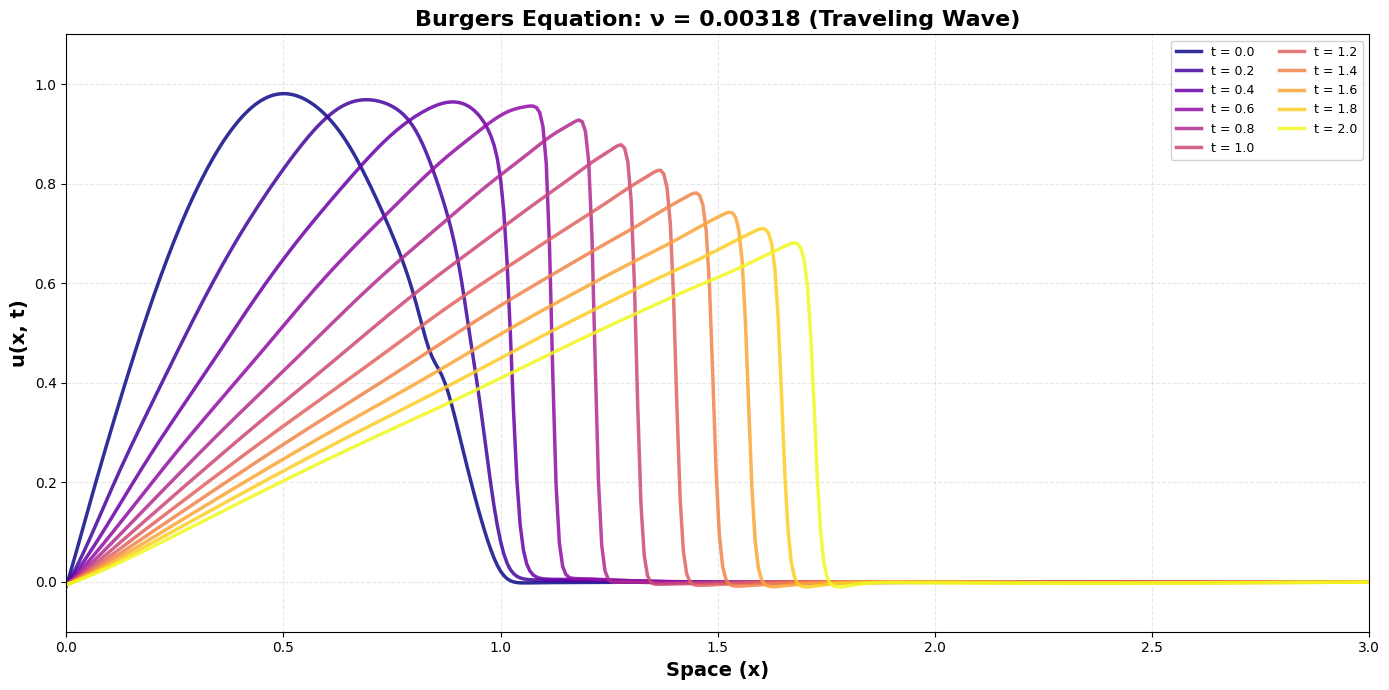

In [48]:
def plot_burgers_time_slices():
    """Plot u vs x at different times for Burgers' equation"""
    fig, ax = plt.subplots(1, 1, figsize=(14, 7))
    
    # Sample times throughout evolution
    time_slices = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]
    x_vals = jnp.linspace(0, 3, 400)  # Higher resolution
    
    colors = plt.cm.plasma(jnp.linspace(0, 1, len(time_slices)))
    
    for idx, t_val in enumerate(time_slices):
        t_vals = jnp.full_like(x_vals, t_val)
        tx_input = jnp.stack([t_vals, x_vals], axis=1)
        u_pred = network(params, tx_input).ravel()
        
        label = f't = {t_val:.1f}'
        ax.plot(x_vals, u_pred, color=colors[idx], linewidth=2.5, 
                label=label, alpha=0.85)
    
    ax.set_xlabel('Space (x)', fontsize=14, fontweight='bold')
    ax.set_ylabel('u(x, t)', fontsize=14, fontweight='bold')
    ax.set_title(f'Burgers Equation: ν = {v:.5f} (Traveling Wave)', 
                 fontsize=16, fontweight='bold')
    ax.set_xlim(0, 3)
    ax.set_ylim(-0.1, 1.1)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(loc='upper right', fontsize=9, framealpha=0.9, ncol=2)
    
    plt.tight_layout()
    plt.savefig('burgers_traveling_wave.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

plot_burgers_time_slices()

## 3D Plot

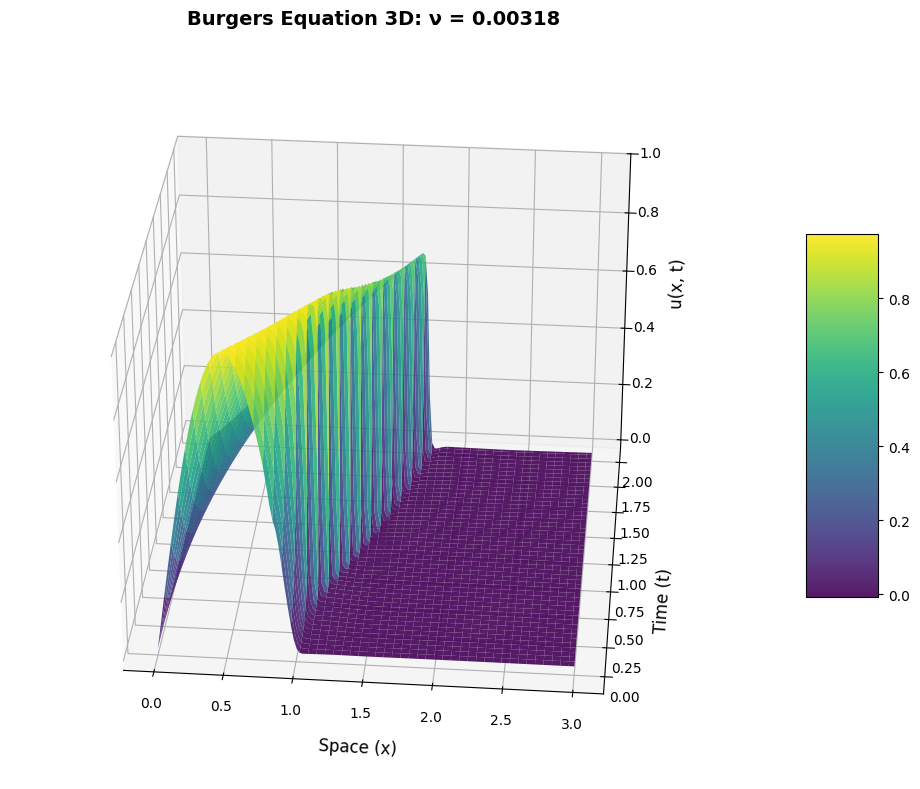

In [49]:
def plot_burgers_3d_surface():
    """3D surface plot of u(x,t)"""
    from mpl_toolkits.mplot3d import Axes3D
    
    fig = plt.figure(figsize=(14, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Create mesh
    t_plot = jnp.linspace(0, 2, 100)
    x_plot = jnp.linspace(0, 3, 150)
    T_grid, X_grid = jnp.meshgrid(t_plot, x_plot)
    
    # Evaluate network
    tx_flat = jnp.stack([T_grid.ravel(), X_grid.ravel()], axis=1)
    U_pred = network(params, tx_flat).reshape(T_grid.shape)
    
    # Plot surface
    surf = ax.plot_surface(X_grid, T_grid, U_pred, cmap='viridis', 
                           edgecolor='none', alpha=0.9)
    
    ax.set_xlabel('Space (x)', fontsize=12, labelpad=10)
    ax.set_ylabel('Time (t)', fontsize=12, labelpad=10)
    ax.set_zlabel('u(x, t)', fontsize=12, labelpad=10)
    ax.set_title(f'Burgers Equation 3D: ν = {v:.5f}', fontsize=14, fontweight='bold', pad=20)
    
    ax.view_init(elev=30, azim=-85)
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
    
    plt.tight_layout()
    plt.savefig('burgers_3d_surface.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

plot_burgers_3d_surface()

## burger evoltuin GIF

In [50]:
from matplotlib.animation import FuncAnimation, PillowWriter

def create_burgers_animation():
    """Create animated GIF of Burgers' equation evolution"""
    
    # Setup
    fig, ax = plt.subplots(figsize=(12, 6))
    x_vals = jnp.linspace(0, 3, 400)
    
    # Time points for animation (more frames = smoother)
    time_points = jnp.linspace(0, 2, 100)  # 100 frames
    
    # Initialize line
    line, = ax.plot([], [], 'b-', linewidth=3, label='PINN Solution')
    time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes, 
                       fontsize=14, verticalalignment='top',
                       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # Set fixed axes
    ax.set_xlim(0, 3)
    ax.set_ylim(-0.1, 1.1)
    ax.set_xlabel('Space (x)', fontsize=14, fontweight='bold')
    ax.set_ylabel('u(x, t)', fontsize=14, fontweight='bold')
    ax.set_title(f'Burgers Equation: ν = {v:.5f}', fontsize=16, fontweight='bold')
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(loc='upper right', fontsize=12)
    
    def init():
        line.set_data([], [])
        time_text.set_text('')
        return line, time_text
    
    def animate(frame):
        t_val = time_points[frame]
        t_vals = jnp.full_like(x_vals, t_val)
        tx_input = jnp.stack([t_vals, x_vals], axis=1)
        u_pred = network(params, tx_input).ravel()
        
        line.set_data(x_vals, u_pred)
        time_text.set_text(f't = {t_val:.3f}')
        return line, time_text
    
    # Create animation
    print("Creating animation... (this may take 30-60 seconds)")
    anim = FuncAnimation(fig, animate, init_func=init,
                        frames=len(time_points), interval=50, 
                        blit=True, repeat=True)
    
    # Save as GIF
    writer = PillowWriter(fps=20)  # 20 frames per second
    anim.save('burgers_evolution_second.gif', writer=writer, dpi=150)
    print("✓ Animation saved as 'burgers_evolution_second.gif'")
    
    plt.close()

create_burgers_animation()

Creating animation... (this may take 30-60 seconds)
✓ Animation saved as 'burgers_evolution_second.gif'


## Residual heat map

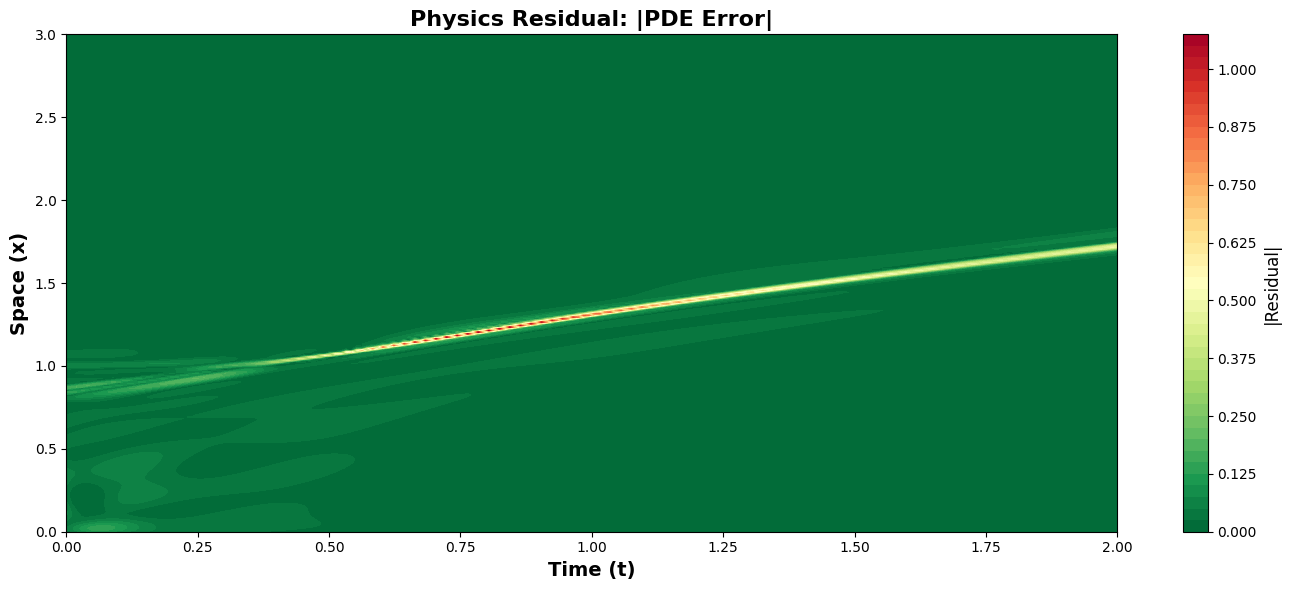

In [52]:
def plot_residual_heatmap():
    """Visualize physics residual across space-time domain"""
    
    # Create dense grid
    t_dense = jnp.linspace(0, 2, 200)
    x_dense = jnp.linspace(0, 3, 300)
    T_grid, X_grid = jnp.meshgrid(t_dense, x_dense)
    
    # Compute residuals at every point
    residuals = physics_residual_batch(params, 
                                      T_grid.ravel(), 
                                      X_grid.ravel(), 
                                      v)
    residuals = residuals.reshape(T_grid.shape)
    
    # Plot
    fig, ax = plt.subplots(figsize=(14, 6))
    im = ax.contourf(T_grid, X_grid, jnp.abs(residuals), 
                     levels=50, cmap='RdYlGn_r')
    ax.set_xlabel('Time (t)', fontsize=14, fontweight='bold')
    ax.set_ylabel('Space (x)', fontsize=14, fontweight='bold')
    ax.set_title('Physics Residual: |PDE Error|', fontsize=16, fontweight='bold')
    
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('|Residual|', fontsize=12)
    
    plt.tight_layout()
    plt.savefig('burgers_residual_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_residual_heatmap()

## Loss curve 

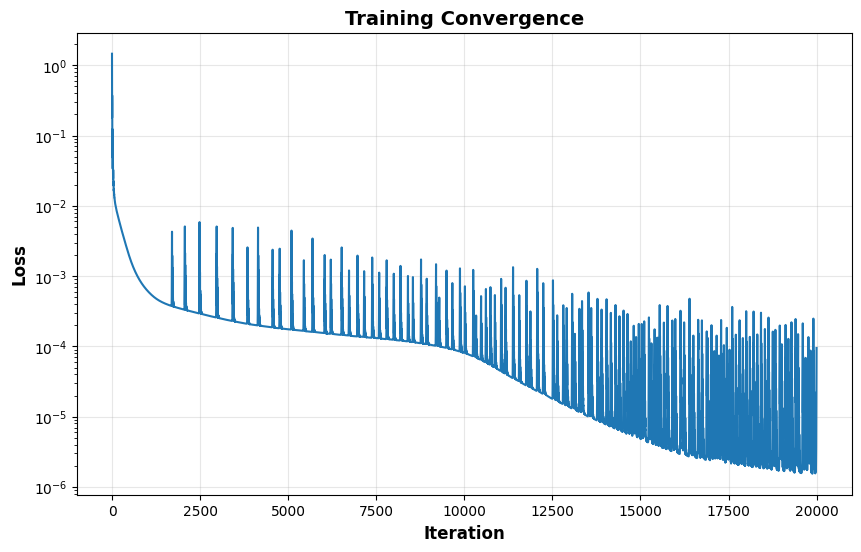

In [53]:
plt.figure(figsize=(10, 6))
plt.semilogy(losses)  # Log scale
plt.xlabel('Iteration', fontsize=12, fontweight='bold')
plt.ylabel('Loss', fontsize=12, fontweight='bold')
plt.title('Training Convergence', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.savefig('loss_curve.png', dpi=300, bbox_inches='tight')
plt.show()